## 이번 강의 목표 

* 규제가 있는 선형회귀 모델의 이해와 구현 
> * 릿지회귀, 라쏘회귀, 엘라스틱넷  


* 또 다른 최적화 기법:  
> * 서브그래디언트(subgradient)를 이용한 경사하강법  
> * 좌표별하강법(coordinate descent)


* 경사하강법과 같은 반복적인 학습 알고리즘을 규제하는 또 다른 방법: **조기 종료(early stopping)**



* 데이터에 대한 전처리와 예측기 학습을 순서대로 처리하도록 도와주는 `sklearn.pipeline` 모듈의 `Pipeline` 클래스의 사용법 이해와 활용 



* 복습이 필요한 Numpy 함수:
> * `np.random.rand`  ([API](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html?highlight=rand#numpy.random.rand))   
> * `np.random.randn` ([API](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html?highlight=randn#numpy.random.randn))  
> * `np.linspace` ([API](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace))   
> * `np.ndarray.reshape` ([API](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html?highlight=reshape#numpy.ndarray.reshape))  
> * `np.logspace` ([API](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html?highlight=logspace#numpy.logspace))  
> * `np.argmax` ([API](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html?highlight=argmax#numpy.argmax))




* 사용할 sklearn 모듈 및 메소드  

        from sklearn.linear_model            import Ridge, Lasso, ElasticNet
        from sklearn.linear_model            import SGDRegressor
        from sklearn.preprocessing           import StandardScaler, PolynomialFeatures
        from sklearn.pipeline                import Pipeline
        from sklearn.model_selection         import train_test_split
        from sklearn.metrics                 import mean_squared_error
        from sklearn.base                    import clone

## 1. 과대적합을 감소시키는 방법: 규제(regularization) 

* 주어진 학습모델의 과대적합을 감소시키기 방법 

> * 모델의 복잡도를 줄이는 것: 예를 들어, 다항회귀 모델의 경우 다항식의 차수를 감소 

* 선형회귀 모델에서는 모델의 가중치를 제한함으로써 규제를 가해 과대적합을 감소시킬 수 있음 : 손실함수 RSS$(\boldsymbol \theta)$에 규제항(regularization term)을 추가한 손실함수 $J(\boldsymbol\theta)$가 최소가 되는 모델 파라미터 $\boldsymbol \theta$를 구함 : 모델의 가중치가 가능한 한 작게 유지되면서 학습 알고리즘이 데이터에 맞추도록 학습 
$$$$
$$ 
\begin{aligned}
J(\boldsymbol\theta)= &\text{RSS}(\boldsymbol\theta)+\alpha\ (||\mathbf w||_p)^p\ \ (\alpha >0)\\
=&\text{RSS}(\boldsymbol\theta ) + \alpha\ \sum_{i=1}^n |\theta_i|^p 
\end{aligned}\cdots\cdots (1)
$$
(단, 모델 파라미터 $\boldsymbol{\theta}=(\theta_0,\theta_1,\cdots,\theta_n)^{\rm T}$에서 $\theta_0$는 절편, $\mathbf w=(\theta_1,\cdots,\theta_n)^{\rm T}$는 가중치)  
> * <span style="color:blue"> 규제항은 학습하는 동안에만 비용함수에 추가되고, 성능을 평가할 때는 MSE로만 평가</span>  
> * $\alpha$는 모델의 가중치를 얼마나 규제할 지를 조절하는 하이퍼파라미터  
>> * $\alpha=0$이면 규제가 없는 선형회귀  
>> * $\alpha$가 아주 크면 모든 가중치가 거의 $0$에 가까워지고, 결국 데이터의 평균을 지나는 수평선에 가까워 짐  
> * <span style="color:blue">규제가 있는 모델에서는 학습을 하기 전에 데이터의 스케일을 맞추는 것이 중요함 </span>
> * $p=2$일 때, 즉, 패널티로 $\ell_2$ 노름(norm)을 사용할 때 릿지회귀 (Ridge regression) 
> * $p=1$일 때, 즉, 패널티로 $\ell_1$ 노름(norm)을 사용할 때 라쏘회귀 (Lasso regression) 
> * 엘라스틱넷(elastic net): 규제항을 릿지회귀의 규제항과 라쏘회귀의 규제항에 대한 내분점으로 정의. 즉, $0\le r\le 1$에 대해 다음과 같이 손실함수를 정의
$$J(\boldsymbol \theta)=\text{RSS}(\boldsymbol\theta ) + r\bigl(\alpha||\mathbf w||_1 \bigr)+(1-r)\bigl({\alpha} ||\mathbf w||_2^2\bigr)$$

* 위의 식 (1)에서 손실함수 $J(\boldsymbol\theta)$가 최소가 되는 $\boldsymbol \theta^*=\text{argmin}_{\boldsymbol\theta}J(\boldsymbol\theta)$를 구하는 것은 $||\mathbf w||_p^p<t$를 만족하는 $\boldsymbol\theta=(\theta_0,\mathbf w^{\rm T})^{\rm T}$에 대해 RSS$(\boldsymbol\theta)$가 최소가 되는 $\boldsymbol\theta$를 구하는 것과 동치임을 보일 수 있다. <span style="color:blue">(나중에 컨벡스 최적화(convex optimization)에 대한 수업을 통해 설명)</span> <span style="color:blue">$\cdots\cdots (2)$</span>


## 2. 릿지회귀 (Ridge regression)

* 릿지회귀를 학습하기 위해 정규방정식을 이용할 수도 있고 경사하강법을 이용할 수도 있음 

* 릿지회귀에 대한 정규방정식  

> * 식 (1)에서 $p=2$인 경우 손실함수 $J(\boldsymbol\theta)$는 아래로 볼록한 함수(convex function)이 되므로 $\nabla_{\boldsymbol\theta}J(\boldsymbol\theta)=\mathbf 0$이 되는 $\boldsymbol\theta$에서 최소가 된다.  

> * $\nabla_{\boldsymbol\theta}J(\boldsymbol\theta) =  2\mathbf X^{\rm T}(\mathbf X\boldsymbol{\theta}-\mathbf y)+2\alpha \mathbf A\boldsymbol\theta=\mathbf 0$에서 $\boldsymbol\theta$를 구하면 
$$ $$
(단, $(n+1)\times (n+1)$ 행렬 $\mathbf A$는 $A_{11}=0$이고 $A_{ii}=1\ (1\le i \le n)$인 대각행렬)  

> * $(\mathbf X^{\rm T}\mathbf X+\alpha  \mathbf A)\boldsymbol\theta  = \mathbf X^{\rm T}\mathbf y$로부터 $\hat{\boldsymbol\theta} = (\mathbf X^{\rm T}\mathbf X +\alpha \mathbf A)^{-1}\mathbf X^{\rm T}\mathbf y$   
>> * 위 식은 확장된 $m$개의 특성벡터 $\mathbf x=(x_0,x_1,\cdots,x_n)^{\rm T}=(1,x_1,\cdots,x_n)^{\rm T}$로부터 생성된 $m\times (n+1)$ 행렬 $\mathbf X$에 대한 식  
>> * $x_0=1$을 추가하지 않은 $m$개의 특성벡터 $\mathbf x$로부터 생성된 $m\times n$ 행렬 $\mathbf X$와 편향(절편) $\theta_0$를 제외한 가중치로만 이루어진 파라미터 $\mathbf w=(\theta_1,\cdots,\theta_n)^{\rm T}$에 대한 정규방정식은 $\hat {\mathbf w}=(\mathbf X^{\rm T}\mathbf X +\alpha \mathbf I_n)^{-1}\mathbf X^{\rm T}\mathbf y$ 

> * 규제가 없는 선형회귀 모델에서 설명했듯이 행렬에 대한 특잇값 분해를 이용하거나 촐레스키 분해(cholesky decomposition)을 이용하여 구현하는 것이 빠름  
>> * 촐레스키 분해: 양의 정부호(positive definite)인 대칭행렬 $\mathbf A$를 하삼각행렬 $\mathbf L$을 이용하여 $\mathbf A=\mathbf L\mathbf L^{\rm T}$와 같이 분해하는 것 ([참고링크](https://en.wikipedia.org/wiki/Cholesky_decomposition))
>> * <span style="color:blue">sklearn.linear_model모듈의 Rigde를 사용하여 예측기 객체를 생성</span> ([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)): `Ridge`객체의 입력 옵션 중 `solver`의 기본값은 'auto'이고 'svd', 'cholesky' 등을 선택할 수 있다. 


* 릿지회귀에 대한 확률적 경사하강법:  
> * <span style="color:blue">sklearn.linear_model 모듈의 SGDRegressor에서 입력변수 `penalty`를 "l2"로 지정하여 예측기 객체를 생성 </span>
> * <span style="color:blue">sklearn.linear_model 모듈의 Ridge에서 입력변수 `solver`를 "sag" 또는 "saga"로 지정하여 예측기 객체를 생성 </span>

## 2.1. 릿지회귀 toy example 

* $[0,3]$에서 $20$개의 $x$를 랜덤하게 생성하고, 정규분포 $N(0,0.1^2)$을 따르는 $\epsilon$에 대해 $Y=1+0.3 X + \epsilon$가 성립하도록 레이블을 생성  


* 규제가 있는 10차 다항회귀를 $3$개의 서로 다른 $\alpha$값에 대해 실험 

In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1) 
y = 1 + 0.3 * X + 0.1 * np.random.randn(m, 1)

In [3]:
X_new = np.linspace(0, 3, 100).reshape(100, 1)
y_new = 1 + 0.3 * X_new + 0.1 * np.random.randn(100, 1)

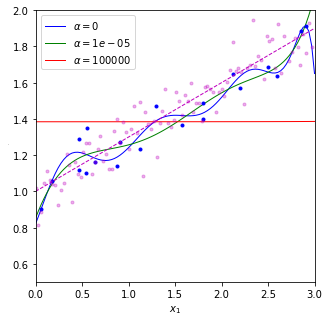

In [4]:
# 규제가 있는 10차 다항회귀 

def plot_model_pre(model_class, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g-", "r-")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        
        poly_features = PolynomialFeatures(degree=10, include_bias=False)
        std_scaler = StandardScaler()
            
        X_poly = poly_features.fit_transform(X)
        X_poly_scaled = std_scaler.fit_transform(X_poly)
        model.fit(X_poly_scaled, y)
        
        y_new_regul = model.predict(std_scaler.transform(poly_features.transform(X_new)))
        plt.plot(X_new, y_new_regul, style, linewidth=1, label=r"$\alpha = {}$".format(alpha))
        
    plt.plot(X, y, "b.", linewidth=3)
    plt.plot(X_new,y_new, "m.", linewidth=3, alpha=0.3)
    plt.plot(X_new, 1+0.3*X_new, "m--", linewidth=1)
    plt.legend(loc="upper left", fontsize=10)
    plt.xlabel("$x_1$", fontsize=10)
    plt.axis([0, 3, 0.5, 2])

plt.figure(figsize=(5,5))
plot_model_pre(Ridge, alphas=(0, 10**-5, 10**5), solver="cholesky", random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=1)
plt.show()

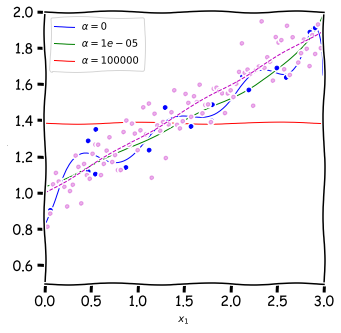

In [5]:
with plt.xkcd():
    plt.figure(figsize=(5,5))
    plot_model_pre(Ridge, alphas=(0, 10**-5, 10**5), solver="saga", random_state=42)
    plt.ylabel("$y$", rotation=0, fontsize=1)
    plt.show()

## Pipeline 클래스를 활용하는 법 

* 앞의 코드에서 보듯이 주어진 속성으로부터 다항식 특성벡터로 변환하고, scaling을 적용한 다음 예측기의 입력으로 전달하는 일련의 과정은 정확한 순서대로 실행되어야 함 

* 연속된 변환을 순서대로 처리하도록 도와주는 <span style="color:blue"> sklearn.pipeline 모듈의 Pipeline 클래스를 이용하면 편리함</span> ([API](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline))    
> * Pipeline은 연속된 단계를 나타내는 이름/변환기(추정기) 쌍의 목록을 입력으로 받는데, 마지막 단계에는 `변환기`와 `추정기`를 모두 사용할 수 있고, 그 외에는 변환기만 가능  
> * 이름은 나중에 하이퍼파라미터를 조정할 때 이용  
> * Pipeline의 `fit()` 메소드를 호출하면 모든 변환기의 `fit_transform()`메소드를 순서대로 호출하면서 해당 단계의 출력을 다음 단계의 입력으로 전달하고, 마지막 단계에서는 `fit()` 메소드만 호출함  
> * Pipeline의 객체는 마지막 추정기와 동일한 메소드를 제공함 

#### Pipeline 클래스를  이용하여 plot_model 함수 다시 구현하기 

In [6]:
from sklearn.pipeline import Pipeline

In [7]:
def plot_model(model_class, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g-", "r-")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        
        model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=1, label=r"$\alpha = {}$".format(alpha))
        
    plt.plot(X, y, "b.", linewidth=3)
    plt.plot(X_new,y_new, "m.", linewidth=3, alpha=0.3)
    plt.plot(X_new, 1+0.3*X_new, "m--", linewidth=1)
    plt.legend(loc="upper left", fontsize=10)
    plt.xlabel("$x_1$", fontsize=10)
    plt.axis([0, 3, 0.5, 2])

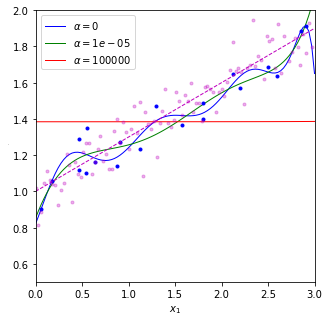

In [8]:
plt.figure(figsize=(5,5))
plot_model(Ridge, alphas=(0, 10**-5, 10**5), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=1)
plt.rcdefaults()
plt.show()

## 2.2. 릿지회귀에서 규제 정도를 조절하는 하이퍼파라미터의 결정 

* 하이퍼파라미터 $\alpha$의 조정: 교차검증을 통해  
> * 여러가지 $\alpha$ 값에 대해 교차검증을 통해 가장 성능이 좋은 $\alpha$를 선택  
> * <span style="color:blue"> sklearn.linear_model 모듈의 RidgeCV 클래스를 이용하면 최적의 $\alpha$에 대한 Ridge 추정기를 쉽게 얻을 수 있음</span> ([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV))  
> * 성능평가 기준은 입력변수 `scoring`에 문자열로 전달  
>> * sklearn에서 score는 큰 값이 좋은 것으로 구현되어 있으므로 MSE로 평가하려면 'neg_mean_squared_error', $R^2$로 평가하려면 'r2'를 전달  
>> * <span style="color:blue">그 외 scoring에 전달할 수 있는 문자열과 대응되는 `sklearn.metrics` 모듈의 함수는 다음 링크의 3.3.1.2를 참고</span> ([API](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter))

In [9]:
my_tr = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler())])
X_tr = my_tr.fit_transform(X)

In [10]:
X_tr[:4]

array([[-0.27730331, -0.51622931, -0.59771496, -0.60210187, -0.57767206,
        -0.54639883, -0.51653147, -0.49043859, -0.46830126, -0.449629  ],
       [ 1.64394295,  1.96057982,  2.16836797,  2.3068604 ,  2.39863669,
         2.45825111,  2.49503096,  2.51510044,  2.52264523,  2.52064204],
       [ 0.91462239,  0.76676347,  0.56688387,  0.37360612,  0.20684303,
         0.07062371, -0.03720869, -0.12079013, -0.18452257, -0.23242128],
       [ 0.47001683,  0.19125759, -0.04223608, -0.20525654, -0.30870164,
        -0.36965751, -0.40257773, -0.41784606, -0.42241897, -0.42078086]])

In [11]:
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3], scoring="r2").fit(X_tr, y)

In [12]:
clf.alpha_

0.1

In [13]:
clf = RidgeCV(alphas=[0.05, 0.1, 0.5], scoring="r2").fit(X_tr, y)
clf.alpha_

0.5

In [14]:
clf = RidgeCV(alphas=[0.1, 0.3, 0.5, 0.6], scoring="r2").fit(X_tr, y)
clf.alpha_

0.3

In [15]:
clf = RidgeCV(alphas=[0.25, 0.3, 0.35], scoring="r2").fit(X_tr, y)
clf.alpha_

0.3

In [16]:
clf.predict(my_tr.transform(X_new[:5]))

array([[1.0350755 ],
       [1.04196859],
       [1.04887989],
       [1.05580933],
       [1.06275684]])

In [17]:
clf.coef_, clf.intercept_

(array([[ 2.04383040e-01,  2.75877253e-02, -2.34940881e-03,
         -8.88173617e-03, -9.55326984e-03, -6.38695956e-03,
          1.88318873e-05,  8.98776960e-03,  1.97985145e-02,
          3.17796667e-02]]),
 array([1.38465065]))

In [18]:
clf.best_score_

0.8660278843491014

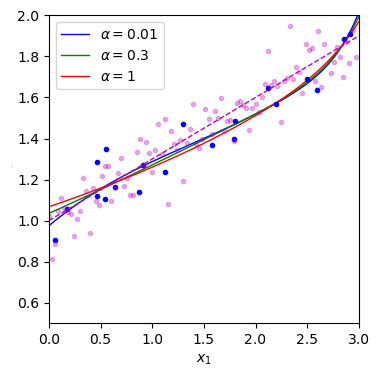

In [19]:
plt.figure(figsize=(4,4))
plot_model(Ridge, alphas=(1e-2, 0.3, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=1)
plt.show()

## 3. 라쏘회귀 (Lasso regression)

* 라쏘회귀의 경우에 릿지회귀의 경우와 달리 손실함수가 최소가 되는 $\boldsymbol\theta$를 해석적으로 구할 수 없으므로 경사하강법 또는 좌표별하강법(coordinate descent)를 이용 
> * 라쏘의 손실함수는 $\theta_i=0$ $(i=1,\cdots,n)$에서 미분 가능하지 않지만, 그래디언트 벡터 대신 서브그래디언트(subgradient) 벡터를 이용하면 경사하강법을 적용할 수 있다.  
>> * $f:\mathbb R^n\to \mathbb R$의 $\boldsymbol \theta=\boldsymbol\theta_0$에서의 서브그래디언트 벡터 $\mathbf v\in \mathbb R^n$는 다음 조건을 만족시키는 임의의 벡터를 의미한다. 
$$f(\boldsymbol\theta)\ge f(\boldsymbol\theta_0)+\mathbf v^{\rm T}(\boldsymbol\theta-\boldsymbol\theta_0)\text{ for all }\boldsymbol\theta\in \mathbb R^n$$ 
$$ $$
>> * 예를 들어 $f(\boldsymbol\theta)=||\boldsymbol\theta||_1=\sum_{i=1}^n|\theta_i|$에 대해 $(\text{sign}(\theta_1),\cdots,\text{sign}(\theta_n))^{\rm T}$는 서브그래디언트 벡터 중 하나가 된다. 단,
$\text{sign}(\theta_i)=\begin{cases} 1 &\text{ if }\theta_i>0 \\ 0 &\text{ if }\theta_i=0\\ -1 & \text{ if }\theta_i<0\end{cases}$   
>> * 미분가능한 점에서의 서브그래디언트 벡터는 그래디언트 벡터 뿐이다.  
$$ $$
>> * <span style="color:blue">함수가 최소가 되는 점에서의 서브그래디언트 벡터 중에는 $\mathbf 0$이 항상 포함됨</span>
$$ $$
> * **좌표별하강법(coordinate desecnt)**:  
>> * 아래로 볼록한 함수 $f$가 모든 점에서 미분가능하면, $\boldsymbol\theta=\mathbf a=(a_1,\cdots,a_n)$에서 $f$가 최소가 된다는  것은 다음 함수 $f_i(t)$가 모두 $t=a_i$에서 최소가 된다는 것과 동치이다. (이것을 간단히 $f$가 각 좌표축에 대해 최소라 하자.)
$$
\begin{aligned}
f_1(t)=&f(t,a_2,a_3,\cdots,a_n)\\
f_2(t)=&f(a_1,t,a_3,\cdots,a_n)\\
&\vdots\\
f_n(t)=&f(a_1,\cdots,a_{n-1},t)
\end{aligned}
$$ 
$$ $$
>> * 아래로 볼록한 함수 $f$가 모든 점에서 미분가능하지 않은 경우에는 일반적으로 위 결과가 성립하지 않는다. 
<img src=".\images\week7\coord_desc.png" width="300">
>> * 하지만, 함수 $f$가 다음과 같이 아래로 볼록한 함수 $g,\ h_i$들의 합 $f(\boldsymbol\theta)=g(\boldsymbol\theta)+\sum_{i=1}^n h_i(\theta_i)$
이고 $g$가 모든 점에서 미분가능한 함수인 경우에는 $f$가 $\boldsymbol\theta=\mathbf a$에서 최소라는 것과 각 좌표축에 대해 최소라는 것이 동치이다.  <span style="color:blue">$\cdots\cdots$ (3)</span>
>>> * 왜냐하면,
$$
\begin{aligned}
\ f(\boldsymbol\theta)-f(\mathbf a) = &g(\boldsymbol\theta)-g(\mathbf a)+\sum_{i=1}^n (h_i(\theta_i)-h_i(a_i))\\
\ge &\nabla_{\boldsymbol\theta}g(\mathbf a)(\boldsymbol\theta -\mathbf a)+\sum_{i=1}^n (h_i(\theta_i)-h_i(a_i))\\
= &\sum_{i=1}^n \left(\dfrac{\partial g}{\partial\theta_i}(\mathbf a)(\theta_i-a_i)+h_i(\theta_i)-h_i(a_i)\right)\ge 0
\end{aligned}
$$
>>> *  위 부등식의 마지막은  
$f$가 $\boldsymbol\theta=\mathbf a$에서 각 좌표축에 최소라는 것으로부터 각 $i=1,\cdots,n$에 대해 $-\dfrac{\partial g}{\partial \theta_i}(\mathbf a)$가 $\theta_i=a_i$에서 $h_i$의 서브그래디언트가 되어  
$$h_i(\theta_i)\ge h_i(a_i)-\dfrac{\partial g}{\partial \theta_i}(\mathbf a)(\theta_i-a_i)$$
이 성립하기 때문 
$$$$
>> * 위 <span style="color:blue">(3)</span>의 상황에서 다음과 같이 반복적으로 각 좌표축을 따라 움직이며 함수의 최솟값을 찾는 최적화 알고리즘을 **좌표별하강법**이라고 함
>>> * $\boldsymbol\theta^{(0)}$를 임의로 선택한 후 다음과 같이 $\boldsymbol\theta^{(k)}$로부터 $\boldsymbol\theta^{(k+1)}$로 업데이트 
$$
\begin{aligned}
\theta_1^{(k+1)} \in\ & \text{argmin}_t f(t,\theta_2^{(k)},\theta_3^{(k)}\cdots,\theta_n^{(k)})\\
\theta_2^{(k+1)} \in\ & \text{argmin}_t f(\theta_1^{(k+1)},t,\theta_3^{(k)},\cdots,\theta_n^{(k)})\\
&\vdots\\
\theta_n^{(k+1)} \in\ & \text{argmin}_t f(\theta_1^{(k+1)},\cdots,\theta_{n-1}^{(k+1)},t)
\end{aligned}
$$
>>> * 위의 반복과정에서 각 좌표축 별로 최소가 되는 $\theta_i$를 구할 때, (서브그래디언트를 이용한) 경사하강법을 적용할 수 있음 
* 라쏘회귀는 릿지회귀에 비해 덜 중요한 특성의 가중치를 제거하는 경향이 있음 : 덜 중요한 특성의 가중치가 $0$이 되므로 여러 개의 특성 중 중요한 특성을 선택하는 효과   
> * 이러한 특성은 첫 번째 단락의 (2)에서 설명한 것과 관련이 있음 
<img src=".\images\week7\l1_l2.png" width="800">
> * 위 왼쪽 그림의 등위선(level curve)은 $\ell_1$ 페널티 $\ell_1(\theta_1,\theta_2)=|\theta_1|+|\theta_2|$를 나타내고, 오른쪽 그림의 등위선은 $\ell_2(\theta_1,\theta_2)=\theta_1^2+\theta_2^2$을 나타냅니다. 
> * 두 경우 모두 $\theta_1=2, \theta_2=0.5$로 초기화하고 경사하강법을 적용하여 각 함수가 최소가 되는 $\boldsymbol\theta$를 구하면  
>> * $\ell_1$의 경우에는 서브그래디언트 벡터가 $(\text{sign}(\theta_1),\text{sign}(\theta_2))^{\rm T}$이므로 $\theta_2$가 먼저 $0$이 되고, $\theta_1$이 $0$이 될 때까지 $\theta_1$ 축을 따라 이동. 
>> * $\ell_2$의 경우에는 그래디언트 벡터가 $2(\theta_1,\theta_2)^{\rm T}$이므로 원점까지 직선을 따라 이동   
>> * 경사하강법의 고정된 학습률에 대해 $\ell_2$의 경우, 원점에 가까워질 수록 업데이트되는 정도가 줄어들면서 수렴. $\ell_1$의 경우에는 학습률을 스케쥴링 하지 않으면 진동 (따라서, 수렴을 시키려면 점진적으로 학습률을 감소시켜야 함)  
$$ $$
> * 실제로 식 (1)의 손실함수에 대한 등위선과 경사하강법으로 학습하는 과정을 그림으로 나타내면 다음과 같다.  
<img src=".\images\week7\lasso_ridge.png" width="800">   
$$ $$
> * 이 과정을 (2)에서 설명한 것처럼 $\boldsymbol\theta$에 제한 범위가 $||\boldsymbol\theta||_p^p\le t$로 주어질 때 $\text{RSS}(\boldsymbol\theta)$의 최솟값을 구하는 것으로 해석하면 아래 그림과 같이 $\ell_1$ 노름의 경우에 $\theta_i=0$이 성립하기 쉬움을 이해할 수 있다. 
<img src=".\images\week7\lasso_ridge2.png" width="800"> 

* 라쏘회귀는 <span style="color:blue"> sklearn.linear_model 모듈의 Lasso 클래스([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)) 또는 SGDRegressor(penalty="l1")을 이용</span>

* 라쏘회귀에서 규제를 조절하는 하이퍼파라미터 $\alpha$를 조정하는 것은 릿지회귀의 경우처럼 교차검증을 이용  
> * 라쏘회귀에 대한 교차검증을 쉽게 하는 방법은 <span style="color:blue">LassoCV</span> ([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV))

## 4. 엘라스틱넷(elastic net)

* 일반적으로 규제가 없는 선형회귀보다는 릿지회귀를 적용하지만, 쓰이는 특성이 몇 개뿐이라고 의심될 때는 라쏘회귀 또는 엘라스틱넷을 적용  


* 특성 수가 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때 라쏘회귀가 문제를 일으킬 수 있는데, 이럴 때 엘라스틱넷을 주로 사용  

* <span style="color:blue"> sklearn.linear_model 모듈의 ElasticNet 클래스 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet)) 또는 SGDRegressor(penalty="elasticnet")을 이용</span>  
> * 엘라스틱넷의 하이퍼파라미터는 규제를 조절하는 $\alpha$에 해당되는 입력변수 `alpha`와 $\ell_1$ 페널티와 $\ell_2$ 패널티를 결합하는 비율을 결정하는 $r$에 해당되는 입력변수 `l1_ratio`를 교차검증을 통해 선택해야 함 

## 5. 객체를 생성한 후 하이퍼파라미터를 수정하는 방법  

* `SGDRegressor`, `Ridge`, `Lasso`, `ElasticNet`의 객체를 생성한 후 파라미터를 수정하기 위해서는 <span style="color:blue">생성된 객체의 set_params(**kwargs) 메소드를 이용</span>하면 됨.  


* `SGDRegressor`, `Ridge`, `Lasso`, `ElasticNet`의 객체를 학습시킨 후(fit) 성능지표로 $R^2$을 계산하기 위해서는  <span style="color:blue">학습된 객체의 score(X, y) 메소드를 이용</span>하면 됨. 


* 이를 이용하여 `ElasticNet`의 규제를 조절하는 `alpha` 하이퍼파라미터를 검증 데이터셋을 이용하여 선택하는 코드를 직접 작성해보자. (단, `l1_ratio=0.7`로 고정)
> * `Ridge`나 `Lasso`의 경우처럼 `ElasticNetCV`를 이용할 수도 있음 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html?highlight=elasticnet#sklearn.linear_model.ElasticNetCV))

### 5.1 코딩 과제 

* 아래 코드에서 #* * * * * * *  로 표시된 부분을 설명내용에 따라 자성하시오. 

In [ ]:
from sklearn.linear_model import ElasticNet

# 데이터셋 생성 
num_train, num_val, num_features = 100, 100, 500
np.random.seed(0)
coef = np.random.randn(num_features)
coef[50:] = 0.0  # 처음 50개의 특성만 모델에 영향을 미치도록 설정 

X = np.random.randn(num_train + num_val, num_features)
y = np.dot(X, coef)

# 훈련 데이터셋과 검증 데이터셋으로 나누기 
X_train, X_val = X[:num_train], X[num_train:]
y_train, y_val = y[:num_train], y[num_train:]

# 훈련 데이터셋과 검증 데이터셋에 대한 성능(r2)을 각각 구함  
alphas = np.logspace(-5, 1, 60)

enet = ElasticNet(l1_ratio=0.7, max_iter=10000)
train_scores = list()
val_scores = list()
for alpha in alphas:
     #* * * * * * *   # 여기에 enet의 `alpha` 파라미터를 재설정하는 코드를 작성하시오.
     #* * * * * * *   # 여기에 재설정된 enet으로 학습을 시키는 코드를 작성하시오. 
    train_scores.append(enet.score(X_train, y_train))
    val_scores.append(enet.score(X_val, y_val))

alpha_optim_idx = #* * * * * * *  # 여기에 성능이 가장 좋은 alpha의 인덱스(alphas에서의)를 구하시오. 
alpha_optim = alphas[alpha_optim_idx]
print(f"가장 좋은 alpha값 : {alpha_optim: .7f}")

# 가장 좋은 alpha 값으로 추정기 재설정 
#* * * * * * *  # 여기에 가장 좋은 `alpha` 파라미터로 enet을 재설정하는 코드를 작성하시오.
coef_ = enet.fit(X, y).coef_

# 결과 그림으로 나타내기 
plt.semilogx(alphas, train_scores, label='Train')
plt.semilogx(alphas, val_scores, label='Validation')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(val_scores), color='k',
           linewidth=1, label='Optimum on validation')
plt.legend(loc='lower center')
plt.ylim([0, 1.2])
plt.xlabel('Regularization hyperparameter')
plt.ylabel(r'$R^2$')
plt.show()

#### 실제 파라미터와 학습된 파라미터의 비교 : 위 코드를 완성한 후 실행하시오. 

In [ ]:
plt.plot(coef, label='True coef', linewidth=1, alpha=0.7)
plt.plot(coef_, label='Estimated coef', linewidth=1, alpha=0.5)
plt.legend()
plt.show()

## 6. 조기 종료(early stopping) 

* 경사하강법과 같이 반복적인 학습 알고리즘을 규제하는 또 다른 방식은 검증에러가 최솟값(검증 성능이 최댓값)에 도달하면 바로 훈련을 중지시키는 것으로 **조기 종료**라고 함  

> * 보통 학습 에포크가 진행됨에 알고리즘이 점차 학습되어 훈련 데이터셋에 대한 오차와 검증 데이터셋에 대한 오차가 모두 줄어들다가, 검증 오차는 다시 상승하기 시작함 (과대적합이 되기 시작)  

> * 조기종료는 검증 오차가 최소에 도달하는 즉시 학습을 멈추는 것 

> * 확률적 경사하강법이나 미니배치 경사하강법과 같이 불규칙하게 움직이며 수렴해가는 경우는 검증 오차가 최솟값에 도달했는지를 확인하기 쉽지 않음   
>> * 검증 오차가 일정 시간 동안 현재까지의 최솟값보다 클 때, 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것으로 극복 
$$ $$
> * 손실함수 $f$가 최소가 되는지를 확인하는 방법  
>> * $|f(\boldsymbol\theta^{(k+1)}-f(\boldsymbol\theta^{(k)}|< \epsilon$  
>> * $||\nabla_{\boldsymbol\theta}f(\boldsymbol\theta)||<\epsilon$

### 6.1 조기 종료 실습  

* `SGDRegressor`에서 `warm_start=True`로 설정하면 `fit()`메소드가 호출될 때 처음부터 다시 학습을 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감 


* 학습률에 대한 스케쥴링을 하지 않고 규제없이 조기종료를 이용하여 학습을 시켜보자.(`penalty=None`, `learning_rate="constant"`)

* 학습된 추정기를 복사하는 방법: <span style="color:blue"> sklearn.base 모듈의 clone을 이용</span> ([API](https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html?highlight=clone#sklearn.base.clone))

* 그림에 화살표를 이용하여 주석을 다는 법: <span style="color:blue">plt.annotate()를 이용</span> ([API](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.annotate.html))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import clone  # 학습된 예측기를 복사 

# 데이터셋 생성 
np.random.seed(42)
m = 100
X2 = 6 * np.random.rand(m, 1) - 3
y2 = 2 + X2 + 0.5 * X2**2 + np.random.randn(m, 1)

# 데이터셋 나누기 
X2_train, X2_val, y2_train, y2_val= train_test_split(X2[:50],y2[:50].ravel(), test_size=0.5, random_state=10)

# 90차 다항식 특성벡터로 확장하고 스케일링 
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X2_train_poly_scaled = poly_scaler.fit_transform(X2_train)
X2_val_poly_scaled = poly_scaler.transform(X2_val)

# 추정기 객체 생성 (`penalty=None`, `learning_rate="constant"`)
sgd_reg = SGDRegressor(max_iter=1, tol= -np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")

best_epoch = None
best_model = None

n_epochs = 1000 
time_limit = 5
time_ctr = 0

for epoch in range(n_epochs):
    sgd_reg.fit(X2_train_poly_scaled, y2_train)  # 중지된 곳에서 다시 시작합니다
    y2_val_predict = sgd_reg.predict(X2_val_poly_scaled)
    val_error = mean_squared_error(y2_val, y2_val_predict)
    time_ctr += 1
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        time_ctr = 0
    if time_ctr >= time_limit:
        break

print(f"best epoch:{best_epoch}")

In [ ]:
# 위 에서 얻은 결과를 그림으로 그리기 
sgd_reg = SGDRegressor(max_iter=1, tol= -np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X2_train_poly_scaled, y2_train)
    y2_train_predict = sgd_reg.predict(X2_train_poly_scaled)
    y2_val_predict = sgd_reg.predict(X2_val_poly_scaled)
    train_errors.append(mean_squared_error(y2_train, y2_train_predict))
    val_errors.append(mean_squared_error(y2_val, y2_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.figure(figsize=(4,4))
###################################################
# 주석달기 
plt.annotate('early stopping',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', arrowstyle='fancy'),
             fontsize=10
            )

plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=0.5)
plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=1, label="Training set")
plt.legend(loc="upper right", fontsize=10)
plt.xlabel("Epoch", fontsize=10)
plt.ylabel("RMSE", fontsize=10)
plt.show()

## 코딩 연습문제   

1) 위 5.1 코딩 과제의 코드를 완성하시오. 


## 이론 연습문제 

1) 릿지회귀를 사용했을 때 훈련오차와 검증오차가 거의 비슷하고 둘 다 비교적 높게 나왔다. 다음 물음에 답하시오.   
> 1-1) 이 모델은 높은 편향와 높은 분산 중 어느 것이 문제인가?  
$$ $$
> 1-2) 이 문제를 해결하려면 규제 하이퍼파라미터 $\alpha$의 값을 높여야 하는가 아니면 낮추어야 하는가?

2) 함수 $f(x)=|x|$의 $x=0$에서의 서브그래디언트가 될 수 있는 값의 범위를 모두 구하시오. 


3) 함수 $f:\mathbb R^n\to \mathbb R$가 아래로 볼록인 함수라는 것은 임의의 두 벡터 $\mathbf x_1, \ \mathbf x_2$와 실수 $t$ ($0\le t \le 1)$에 대하여 다음 성질을 만족하는 함수라는 뜻이다. 
$$f(t\mathbf x_1+(1-t)\mathbf x_2)\le tf(\mathbf x_1)+(1-t)f(\mathbf x_2)$$  
> 3-1) $\mathbb R^n$에서 정의된 두 함수 $f,\ g$가 각각 아래로 볼록한 함수일 때, $f+g$도 아래로 볼록한 함수가 됨을 보이시오.  
$$ $$
> 3-2) $f:\mathbb R^n\to \mathbb R$가 아래로 볼록한 함수이고, $\mathbf x=\mathbf a$에서 미분가능하면, 모든 $\mathbf x\in \mathbb R^n$에 대하여 다음 식이 성립함을 보이시오. 
$$f(\mathbf x)\ge f(\mathbf a)+\nabla_{\mathbf x}f(\mathbf a)^{\rm T}(\mathbf x-\mathbf a)$$